In [1]:
from langchain.schema import Document
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_community.vectorstores import Chroma

In [2]:
import os
from dotenv import load_dotenv

load_dotenv()

os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [3]:
embeddings = GoogleGenerativeAIEmbeddings(model="text-embedding-004")

embeddings

GoogleGenerativeAIEmbeddings(client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x769a2ad21590>, async_client=<google.ai.generativelanguage_v1beta.services.generative_service.async_client.GenerativeServiceAsyncClient object at 0x769a2ad81a10>, model='models/text-embedding-004', task_type=None, google_api_key=SecretStr('**********'), credentials=None, client_options=None, transport=None, request_options=None)

In [4]:
docs = [
    Document(
        page_content="Peak Performance Gym was founded in 2015 by former Olympic athlete Marcus Chen. With over 15 years of experience in professional athletics, Marcus established the gym to provide personalized fitness solutions for people of all levels. The gym spans 10,000 square feet and features state-of-the-art equipment.",
        metadata={"source": "about.txt"}
    ),
    Document(
        page_content="Peak Performance Gym is open Monday through Friday from 5:00 AM to 11:00 PM. On weekends, our hours are 7:00 AM to 9:00 PM. We remain closed on major national holidays. Members with Premium access can enter using their key cards 24/7, including holidays.",
        metadata={"source": "hours.txt"}
    ),
    Document(
        page_content="Our membership plans include: Basic (₹1,500/month) with access to gym floor and basic equipment; Standard (₹2,500/month) adds group classes and locker facilities; Premium (₹4,000/month) includes 24/7 access, personal training sessions, and spa facilities. We offer student and senior citizen discounts of 15% on all plans. Corporate partnerships are available for companies with 10+ employees joining.",
        metadata={"source": "membership.txt"}
    ),
    Document(
        page_content="Group fitness classes at Peak Performance Gym include Yoga (beginner, intermediate, advanced), HIIT, Zumba, Spin Cycling, CrossFit, and Pilates. Beginner classes are held every Monday and Wednesday at 6:00 PM. Intermediate and advanced classes are scheduled throughout the week. The full schedule is available on our mobile app or at the reception desk.",
        metadata={"source": "classes.txt"}
    ),
    Document(
        page_content="Personal trainers at Peak Performance Gym are all certified professionals with minimum 5 years of experience. Each new member receives a complimentary fitness assessment and one free session with a trainer. Our head trainer, Neha Kapoor, specializes in rehabilitation fitness and sports-specific training. Personal training sessions can be booked individually (₹800/session) or in packages of 10 (₹7,000) or 20 (₹13,000).",
        metadata={"source": "trainers.txt"}
    ),
    Document(
        page_content="Peak Performance Gym's facilities include a cardio zone with 30+ machines, strength training area, functional fitness space, dedicated yoga studio, spin class room, swimming pool (25m), sauna and steam rooms, juice bar, and locker rooms with shower facilities. Our equipment is replaced or upgraded every 3 years to ensure members have access to the latest fitness technology.",
        metadata={"source": "facilities.txt"}
    )
]

In [5]:
db = Chroma.from_documents(docs, embeddings)

db

In [6]:
retriever = db.as_retriever(search_type="mmr", search_kwargs={"k": 3})

retriever

VectorStoreRetriever(tags=['Chroma', 'GoogleGenerativeAIEmbeddings'], vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x769a2ada7bd0>, search_type='mmr', search_kwargs={'k': 3})

In [7]:
retriever.invoke("Who is the owner and what are the timings?")

[Document(metadata={'source': 'membership.txt'}, page_content='Our membership plans include: Basic (₹1,500/month) with access to gym floor and basic equipment; Standard (₹2,500/month) adds group classes and locker facilities; Premium (₹4,000/month) includes 24/7 access, personal training sessions, and spa facilities. We offer student and senior citizen discounts of 15% on all plans. Corporate partnerships are available for companies with 10+ employees joining.'),
 Document(metadata={'source': 'hours.txt'}, page_content='Peak Performance Gym is open Monday through Friday from 5:00 AM to 11:00 PM. On weekends, our hours are 7:00 AM to 9:00 PM. We remain closed on major national holidays. Members with Premium access can enter using their key cards 24/7, including holidays.'),
 Document(metadata={'source': 'trainers.txt'}, page_content='Personal trainers at Peak Performance Gym are all certified professionals with minimum 5 years of experience. Each new member receives a complimentary fitn

In [8]:
from langchain.tools.retriever import create_retriever_tool
from langchain_core.tools import tool

In [9]:
retriever_tool = create_retriever_tool(
    retriever,
    "retriever_tool",
    "Information related to Gym History & Founder, Operating Hours, Membership Plans, Fitness Classes, Personal Trainers, and Facilities & Equipment of Peak Performance Gym",
)

In [10]:
@tool
def off_topic_tool():
    """Catch all Questions NOT related to Peak Performance Gym's history, hours, membership plans, fitness classes, trainers, or facilities"""
    return "Forbidden - do not respond to the user"

In [11]:
tools = [retriever_tool, off_topic_tool]

In [12]:
from typing import TypedDict, Annotated, Sequence, Literal
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_groq import ChatGroq
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode

In [13]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [14]:
def agent(state):
    messages = state["messages"]
    model = ChatGroq(model="llama-3.3-70b-versatile")
    model = model.bind_tools(tools=tools)
    response = model.invoke(messages)
    return { "messages": [response] }

In [15]:
def should_continue(state) -> Literal["tools", END]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END

In [17]:
workflow = StateGraph(AgentState)

tool_node = ToolNode(tools)

workflow.add_node("agent", agent)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
)
workflow.add_edge("tools", "agent")

graph = workflow.compile()

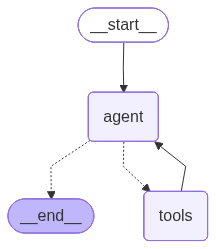

In [18]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [20]:
graph.invoke(input={
    "messages": [HumanMessage(content="Who is the owner and what are the timings?")]
})

{'messages': [HumanMessage(content='Who is the owner and what are the timings?', additional_kwargs={}, response_metadata={}, id='16935c44-217b-48b2-8953-b717ca2acf10'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'zpw4m4xf0', 'function': {'arguments': '{"query":"Gym History \\u0026 Founder, Operating Hours"}', 'name': 'retriever_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 368, 'total_tokens': 391, 'completion_time': 0.076241977, 'prompt_time': 0.030866051, 'queue_time': 0.084258563, 'total_time': 0.107108028}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_9e1e8f8435', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--930fc53e-057d-47a2-8c39-21d389398242-0', tool_calls=[{'name': 'retriever_tool', 'args': {'query': 'Gym History & Founder, Operating Hours'}, 'id': 'zpw4m4xf0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 368, 'output_tok

In [21]:
graph.invoke(
    input={"messages": [HumanMessage(content="What is the Apple's latest stock price?")]}
)

{'messages': [HumanMessage(content="What is the Apple's latest stock price?", additional_kwargs={}, response_metadata={}, id='c9242fe0-55dd-4474-9c82-ddf31abb3434'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 's5hzd65hs', 'function': {'arguments': 'null', 'name': 'off_topic_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 367, 'total_tokens': 377, 'completion_time': 0.040170179, 'prompt_time': 0.0313925, 'queue_time': 0.152482477, 'total_time': 0.071562679}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_155ab82e98', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--e9d39101-5940-421f-8b5b-480a85e7bcc9-0', tool_calls=[{'name': 'off_topic_tool', 'args': {}, 'id': 's5hzd65hs', 'type': 'tool_call'}], usage_metadata={'input_tokens': 367, 'output_tokens': 10, 'total_tokens': 377}),
  ToolMessage(content='Forbidden - do not respond to the user', name='off